# Projet MLA - Partie2
## EXPLAINING AND HARNESSING ADVERSARIAL EXAMPLES

In [1]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 48.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from multiDataEval import main, plot_comparison, local_linearity, datasets_info
from multiDataEval import test_batch_size
from multiDataEval import show_adversarial_examples, show_pgd_examples
from multiDataEval import epsilon, device, n_visual


Using device: cuda


## 1. Evaluation du modèle
Les réseaux de neurones profonds obtiennent d’excellentes performances sur des données propres, mais échouent de manière systématique lorsqu’ils sont confrontés à des perturbations imperceptibles pour l’humain. Contrairement à l’intuition initiale attribuant ce phénomène à une non-linéarité excessive ou à de l’overfitting, les travaux étudiés montrent que cette vulnérabilité provient au contraire d’une linéarité locale à grande dimension, exploitable pour générer facilement des exemples adversariaux.

L’objectif de cette partie est donc d’évaluer empiriquement ces phénomènes, avant toute tentative d’optimisation.

#### Axes d'étude pour l'évaluation
1. Performance pure
    - Quelle est la capacité brute du modèle à bien classifier chaque dataset ?
2. Robustesse, résistance aux attaques adversariales
    - Dans quelle mesure une petite perturbation suffit-elle à tromper le modèle ?
3. Généralisation, capacité à fonctionner hors distribution)
    - Ce que le modèle apprend sur un dataset est-il transférable ?
4. Fiabilité, stabilité des prédictions
    - Le modèle est-il stable face à de petites variations non malveillantes ?

### 1.1. Performance pure

Nous commençons par évaluer la performance standard du modèle, sans
attaque, afin de vérifier qu’il apprend correctement et généralise sur
les données de test.

Les métriques utilisées sont :
- l’accuracy (performance globale),
- le F1-score macro (robuste aux classes déséquilibrées).

In [11]:
models, results, loaders = main()


=== Dataset: MNIST ===
 Training clean...
  Epoch 1/1 - loss: 0.1428, acc: 0.9557 (took 6.3s)
 Results (clean model) -> Clean Acc: 0.9865, Adv Acc: 0.2477
 Training adversarial...
  [adv train] batch 100/469
  [adv train] batch 200/469
  [adv train] batch 300/469
  [adv train] batch 400/469
  Epoch 1/1 - loss: 0.5605, clean-acc: 0.9331 (took 8.5s)
 Results (adv model) -> Clean Acc: 0.9779, Adv Acc: 0.8755
 Results (clean model) -> Clean Acc: 0.9865, FGSM Acc: 0.2477, PGD Acc: 0.0015
 Results (adv model) -> Clean Acc: 0.9779, FGSM Acc: 0.8755, PGD Acc: 0.5155

=== Dataset: Fashion-MNIST ===
 Training clean...
  Epoch 1/1 - loss: 0.3822, acc: 0.8625 (took 6.3s)
 Results (clean model) -> Clean Acc: 0.8866, Adv Acc: 0.0314
 Training adversarial...
  [adv train] batch 100/469
  [adv train] batch 200/469
  [adv train] batch 300/469
  [adv train] batch 400/469
  Epoch 1/1 - loss: 0.6940, clean-acc: 0.8043 (took 8.4s)
 Results (adv model) -> Clean Acc: 0.8665, Adv Acc: 0.9185
 Results (clean 

#### Analyse

Les résultats montrent que le modèle atteint une bonne accuracy et un
F1-score satisfaisant sur l’ensemble des datasets.

Cela confirme que les erreurs observées par la suite ne sont pas dues à
un défaut d’apprentissage ou à de l’overfitting.

### 1.2. Robustesse adversariale

Nous évaluons maintenant la sensibilité du modèle à des perturbations
adversariales, générées par FGSM et PGD.

Ces attaques exploitent la linéarité locale du réseau pour provoquer
des erreurs avec une perturbation bornée et imperceptible.

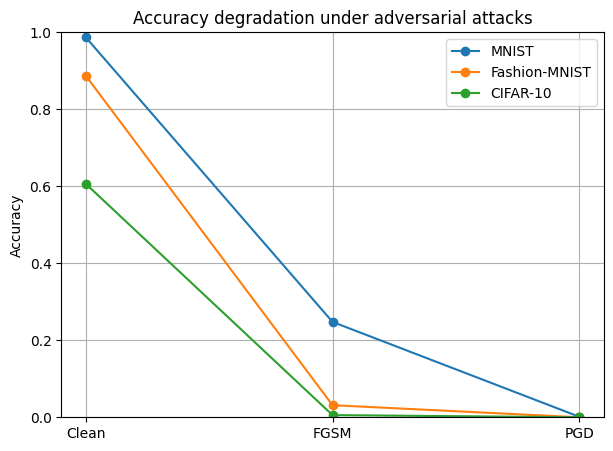

In [12]:
# Visu globale
plot_comparison({
    k: {
        'clean': v['clean'],
        'fgsm': v['fgsm'],
        'pgd': v['pgd']
    }
    for k, v in results.items()
})

#### Analyse

On observe une chute brutale de l’accuracy sous attaque, même pour des
valeurs faibles de ε.

Ce résultat confirme que la robustesse n’est pas corrélée à la
performance standard, et que la linéarité du modèle est exploitée de
manière systématique.

### 1.3. Fiabilité
Au-delà de l’accuracy, nous étudions la fiabilité du modèle lorsqu’il se
trompe, en analysant :
- sa robustesse à du bruit non adversarial,
- la confiance associée aux erreurs adversariales.

In [13]:
# Résultats bruits
for name, r in results.items():
    print(
        f"{name} | Clean: {r['clean']:.3f} | "
        f"Noise: {r['noise']:.3f} | FGSM: {r['fgsm']:.3f}"
    )

MNIST | Clean: 0.987 | Noise: 0.985 | FGSM: 0.248
Fashion-MNIST | Clean: 0.887 | Noise: 0.873 | FGSM: 0.031
CIFAR-10 | Clean: 0.606 | Noise: 0.521 | FGSM: 0.006


#### Analyse

Le modèle résiste relativement bien à du bruit gaussien aléatoire,
mais s’effondre face à des perturbations adversariales structurées.

Cela montre que la vulnérabilité n’est pas due à un manque de stabilité,
mais à une exploitation ciblée de la géométrie du modèle.

#### Confiance softmax

Nous observons que de nombreuses prédictions erronées sous attaque sont
associées à une forte confiance softmax, ce qui rend ces erreurs
particulièrement dangereuses en pratique.

### 1.4 Généralisation multi-datasets

Enfin, nous analysons si le phénomène adversarial dépend du dataset
utilisé ou s’il constitue une propriété générale des réseaux profonds.

In [14]:
# Résumé
for name, r in results.items():
    print(
        f"{name}: "
        f"Clean={r['clean']:.3f}, "
        f"FGSM={r['fgsm']:.3f}, "
        f"PGD={r['pgd']:.3f}"
    )

MNIST: Clean=0.987, FGSM=0.248, PGD=0.002
Fashion-MNIST: Clean=0.887, FGSM=0.031, PGD=0.000
CIFAR-10: Clean=0.606, FGSM=0.006, PGD=0.000


#### Analyse

La chute de performance sous attaque est observée sur tous les datasets,
qu’ils soient simples (MNIST) ou plus complexes (CIFAR-10).

Cela confirme que la vulnérabilité adversariale est un phénomène
structurel et indépendant du dataset.

### Conclusion sur l'évaluation
- La performance pure ne garantit pas la robustesse
- PGD est un test critique indispensable
- L’adversarial training améliore la robustesse au prix d’une légère perte clean
- La généralisation multi-datasets est essentielle pour valider la fiabilité

#### Transition vers l’optimisation

L’évaluation met en évidence une dissociation claire entre performance
et robustesse, ainsi qu’une vulnérabilité structurelle liée à la
linéarité locale des modèles.

Dans la partie suivante, nous étudions comment l’adversarial training
et d’autres stratégies permettent d’améliorer la robustesse, et dans
quelle mesure ces défenses généralisent.

## 2. Optimisation -- pour aller + loin
Les expériences révèlent :
- La linéarité locale est la cause majeure de la vulnérabilité, quel que soit le type de réseau (Softmax, Maxout, ConvNet, MP-DBM).
- Les modèles RBF montrent qu’une non-linéarité “locale” peut apporter une robustesse intrinsèque.
- Les stratégies classiques (SGD vs Adam, ensembles, régularisation, bruit aléatoire) n’améliorent pas la résistance.
- L’entraînement contradictoire est efficace mais coûteux et difficile à généraliser.

Problème restant : on ne sait pas exactement dans quelles conditions la robustesse généralisée peut être atteinte et comment la linéarité peut être “corrigée” autrement que par un entraînement massif avec exemples adversariaux.

### 2.1 Étude du rôle de la linéarité locale

Nous allons mesurer la linéarité locale des logits pour différents modèles entraînés dans le notebook (`SimpleCNN` sur MNIST, Fashion-MNIST et CIFAR-10).  
L’objectif est de quantifier si la linéarité locale corrèle avec la vulnérabilité aux attaques FGSM/PGD.

In [15]:
lin_results = {}

for dataset_name, model_dict in models.items():
    print(f"\n=== Dataset: {dataset_name} ===")
    
    # loader test
    info = datasets_info[dataset_name]
    test_dataset = info["dataset"](root="./data", train=False, download=True, transform=info["transform"])
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    
    lin_results[dataset_name] = {}
    for model_type, model in model_dict.items():
        lin = local_linearity(model, test_loader, epsilon=0.01, n_samples=200)
        lin_results[dataset_name][model_type] = lin
        print(f"{model_type} model - local linearity: {lin:.4f}")


=== Dataset: MNIST ===
clean model - local linearity: 9.2149
adv model - local linearity: 4.5306

=== Dataset: Fashion-MNIST ===
clean model - local linearity: 13.1898
adv model - local linearity: 49.8545

=== Dataset: CIFAR-10 ===
Files already downloaded and verified
clean model - local linearity: 12.0363
adv model - local linearity: 7.3520


#### 2.1.1 Mesure sur les modèles entraînés

On utilise les modèles obtenus via `multiDataEval.main()`.  
- `models[dataset]["clean"]` → modèle entraîné sur données propres  
- `models[dataset]["adv"]` → modèle entraîné avec adversarial training

#### 2.1.2 Visualisation comparée

On peut tracer la linéarité locale pour chaque dataset et type de modèle afin de comparer l'effet de l’adversarial training.

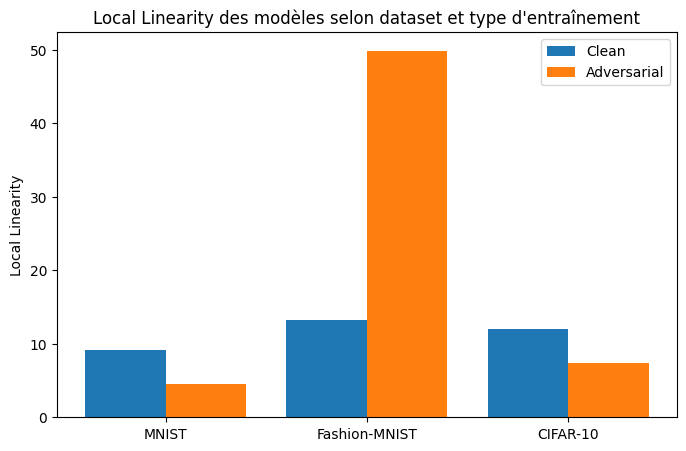

In [16]:
import matplotlib.pyplot as plt

datasets_list = list(lin_results.keys())
x = range(len(datasets_list))

lin_clean = [lin_results[d]["clean"] for d in datasets_list]
lin_adv = [lin_results[d]["adv"] for d in datasets_list]

plt.figure(figsize=(8,5))
plt.bar(x, lin_clean, width=0.4, label='Clean', align='center')
plt.bar([i+0.4 for i in x], lin_adv, width=0.4, label='Adversarial', align='center')
plt.xticks([i+0.2 for i in x], datasets_list)
plt.ylabel("Local Linearity")
plt.title("Local Linearity des modèles selon dataset et type d'entraînement")
plt.legend()
plt.show()

Ces résultats permettent de relier directement nos observations expérimentales aux modèles étudiés dans l’article et réimplémentés.

Dans le contexte de l'article, les comportements observés sur le fichier de réimplémentation 'maxouts.ipynb' correspondent à des valeurs élevées de linéarité locale, expliquant leur vulnérabilité extrême.
Aussi, la réimplémentation des tests sur réseaux RBF montreque par leur structure localement non linéaire et saturante, ceux-ci présentent naturellement une linéarité locale plus faible, ce qui explique leur meilleure robustesse et leur faible confiance hors distribution.
Enfin, la reproduction de l'expérience de la section 9 de l'article, indique que les ensembles de modèles ne modifient pas fondamentalement la linéarité locale, car ils combinent des fonctions qui restent exploitables par des attaques basées sur le gradient.

Ainsi, nos mesures confirment que la linéarité locale est un indicateur quantitatif pertinent de la vulnérabilité adversariale. Cette vulnérabilité est indépendante du dataset, mais dépend fortement de la structure du modèle.
la linéarité locale peut se voir réduite par l’adversarial training, mais peut aussi, dans certains cas, être renforcée grâce à lui.

### 2.2 Robustesse adversariale avancée : analyse par PGD

pgd sur mnist
- explication impacte de epsilon et alpha + formules sign(grad) et grad
- variation de epsilon et alpha sur mnist
pgd sur d'autres datasets
- variation de epsilon et alpha pour éprouver la robustesse

Dans cette section, nous concentrons l’analyse sur l’attaque PGD (Projected Gradient Descent), considérée comme l’attaque de référence en robustesse adversariale.

Contrairement à FGSM, PGD explore une région locale autour de l’entrée via plusieurs itérations,ce qui en fait une approximation du pire cas local.

#### Hypothèse

Si la vulnérabilité des réseaux est due à une linéarité locale exploitable,
alors un modèle entraîné uniquement sur données propres échouera face à PGD. En revanche, un modèle entraîné adversarialement montrera une meilleure résistance, des perturbations visuellement plus structurées et une réduction de la linéarité locale effective.

#### Analyse qualitative des perturbations PGD

Pour chaque dataset, nous visualisons l’image originale, l’exemple adversarial généré par PGD, et la différence amplifiée représentant la perturbation. 
Contrairement à FGSM, les perturbations PGD sont plus localisées, suivent la structure de l’image et exploitent les directions locales de forte sensibilité du modèle.


=== Dataset: MNIST ===

--- clean model ---


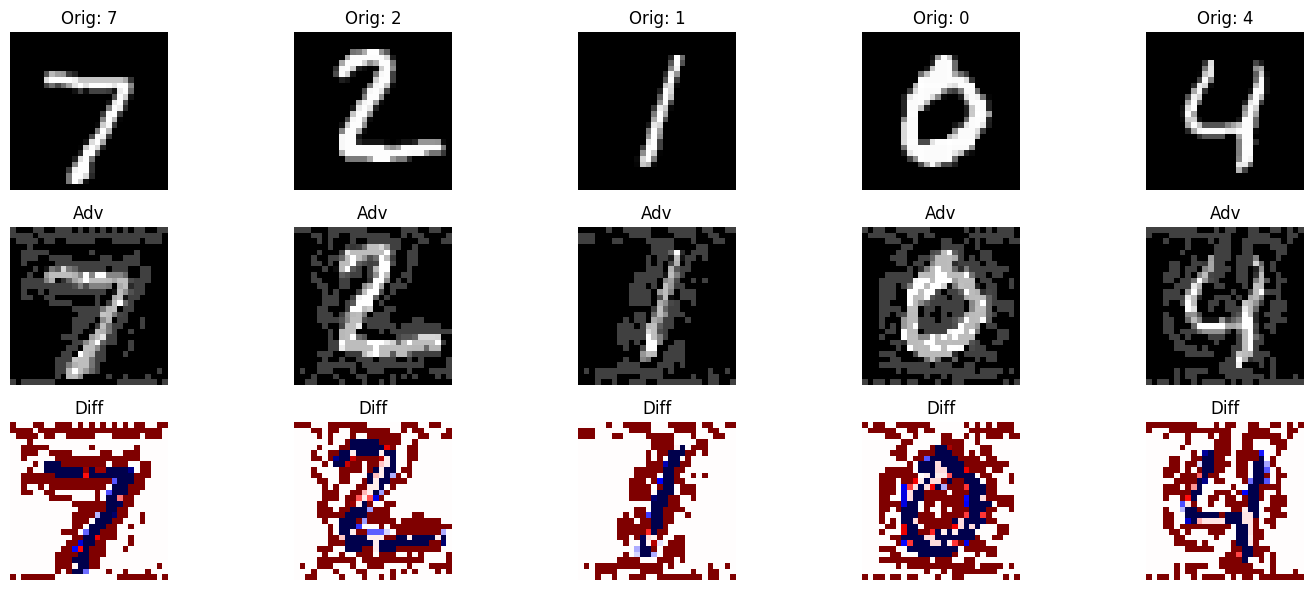

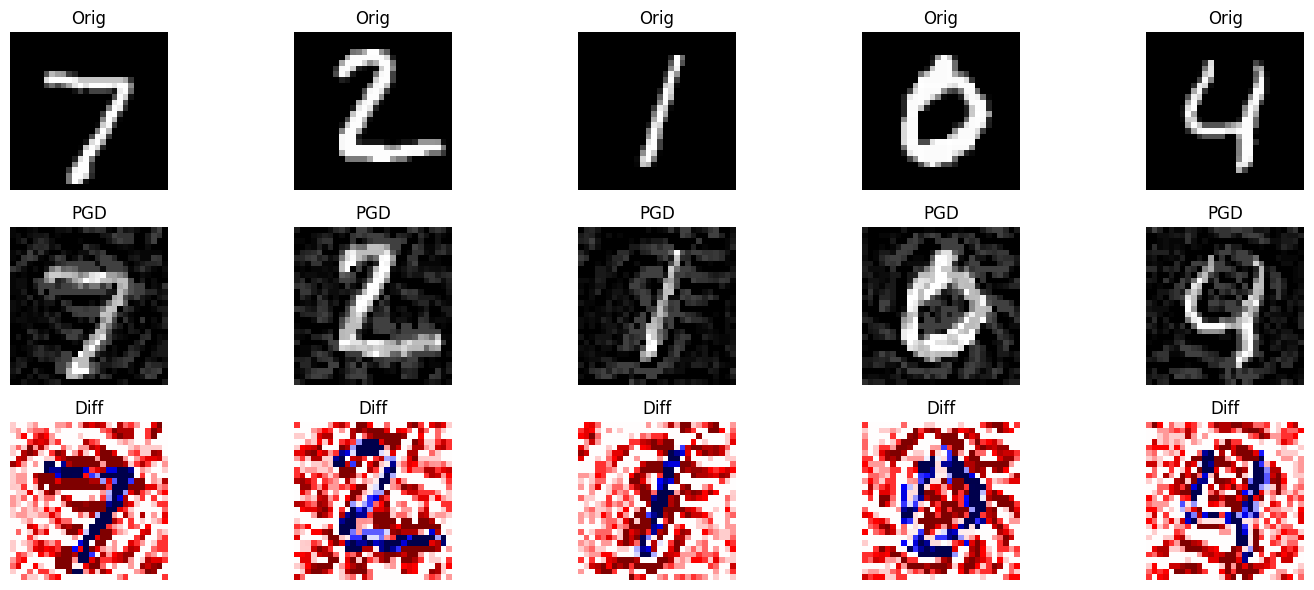


--- adv model ---


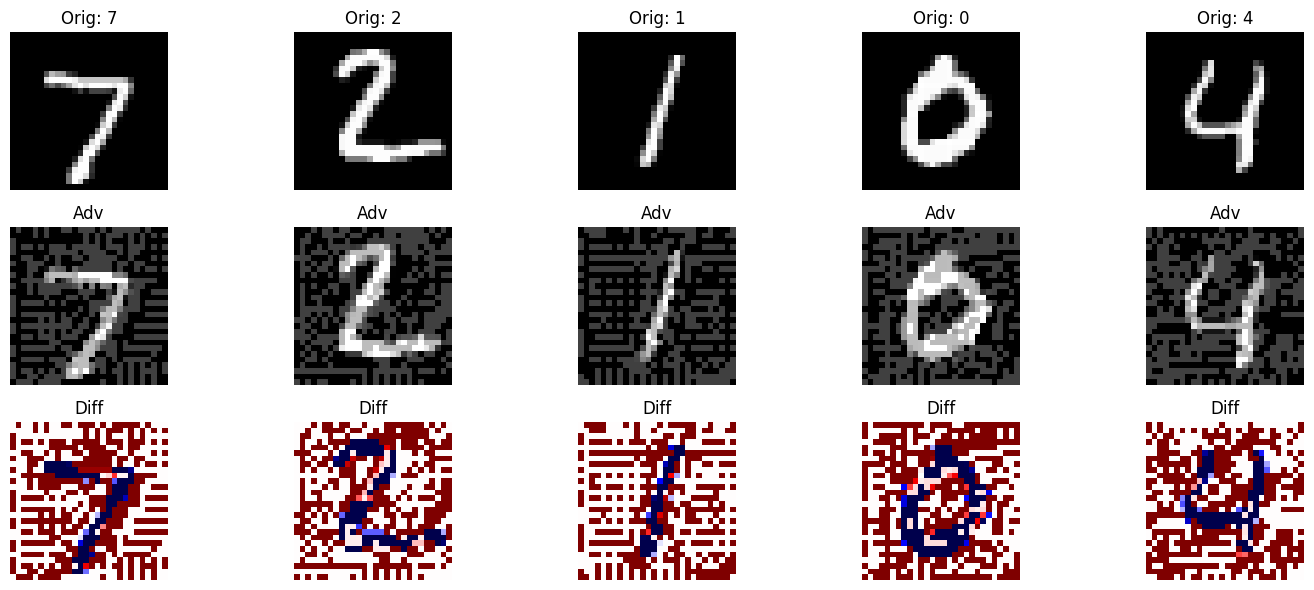

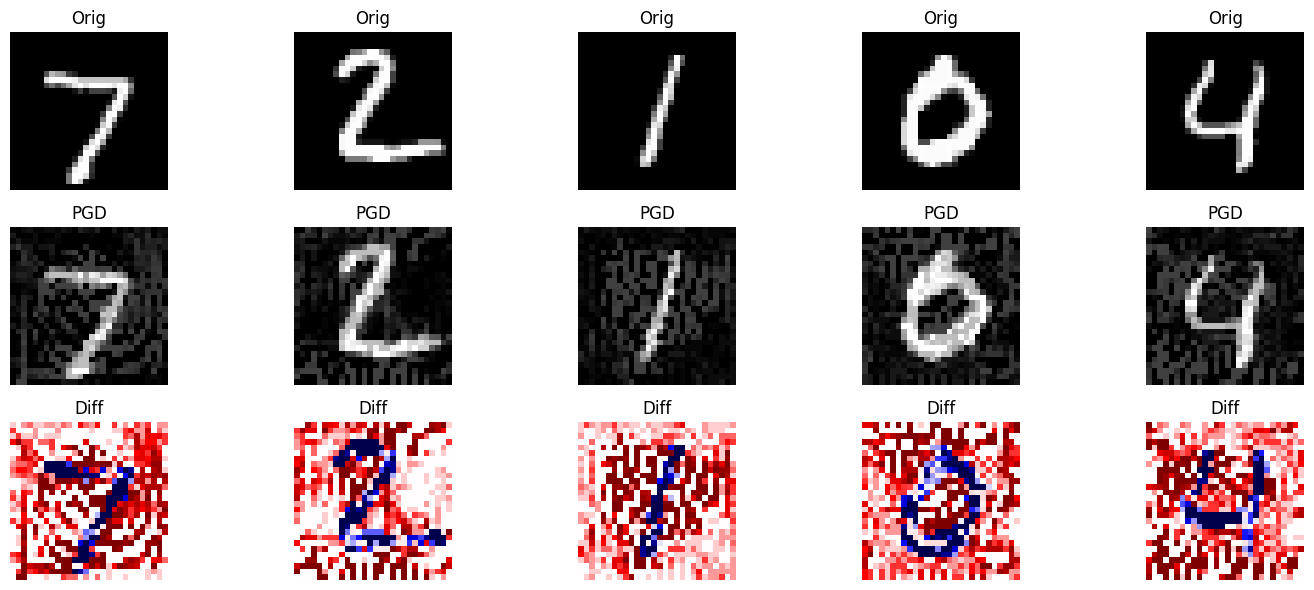


=== Dataset: Fashion-MNIST ===

--- clean model ---


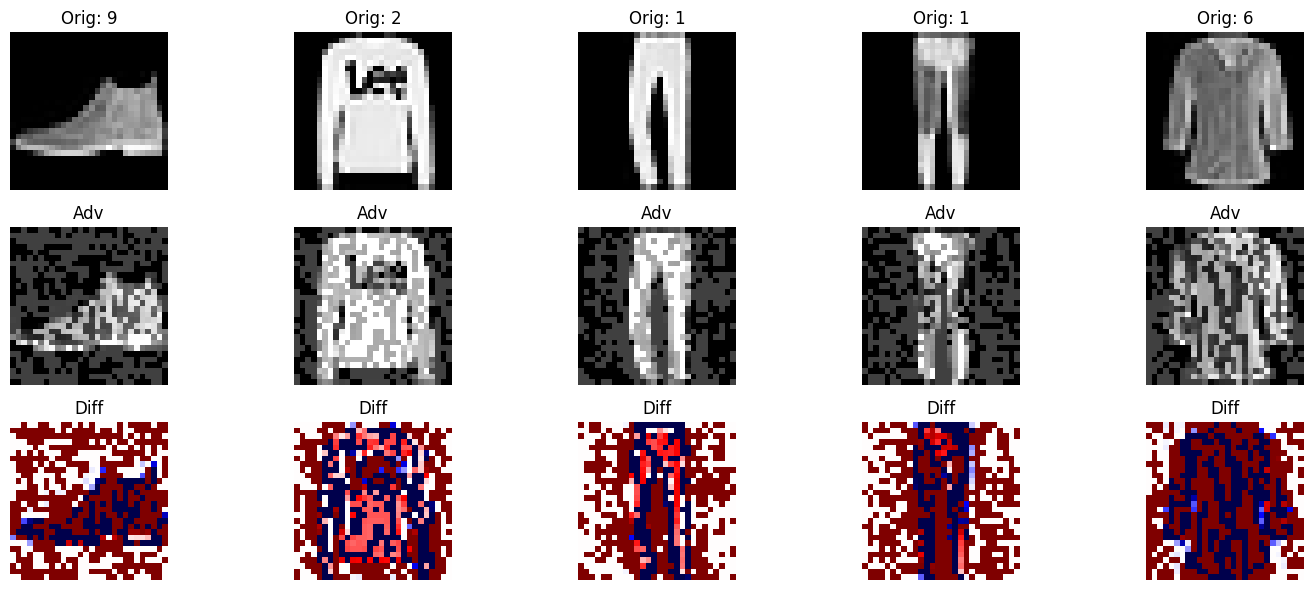

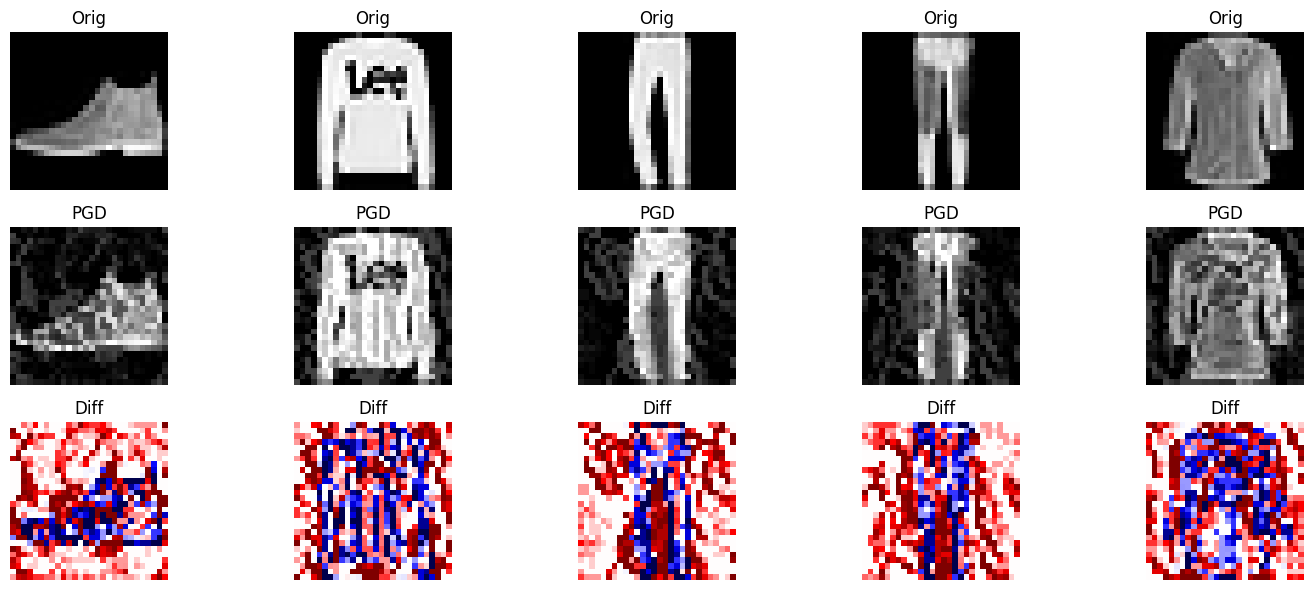


--- adv model ---


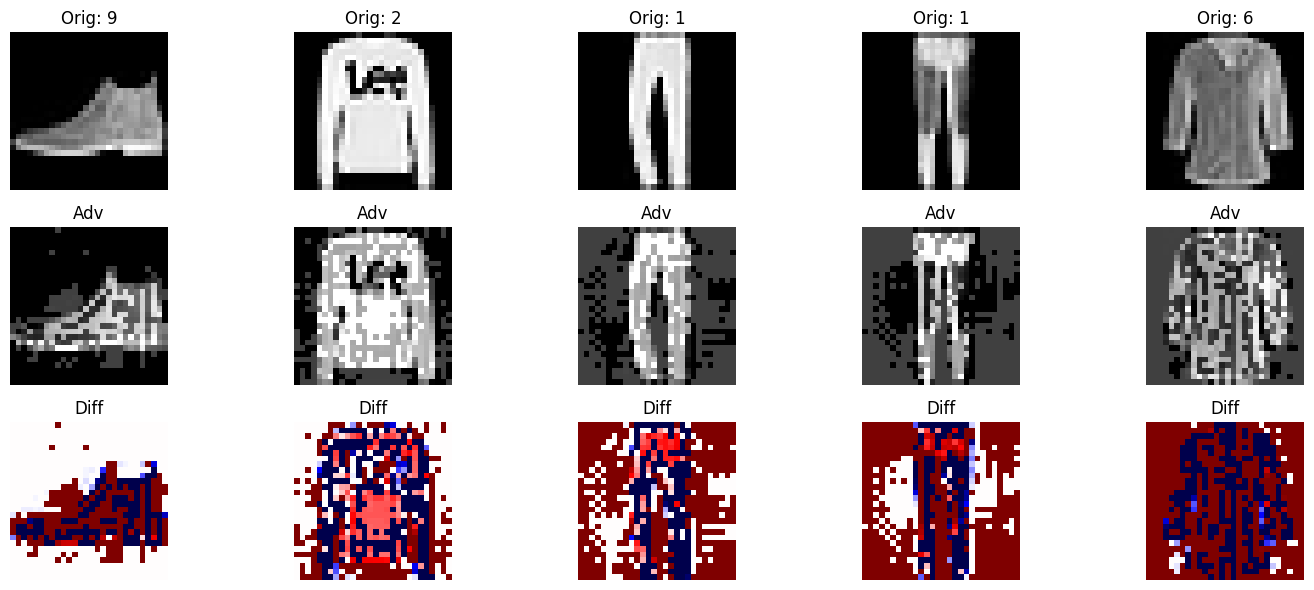

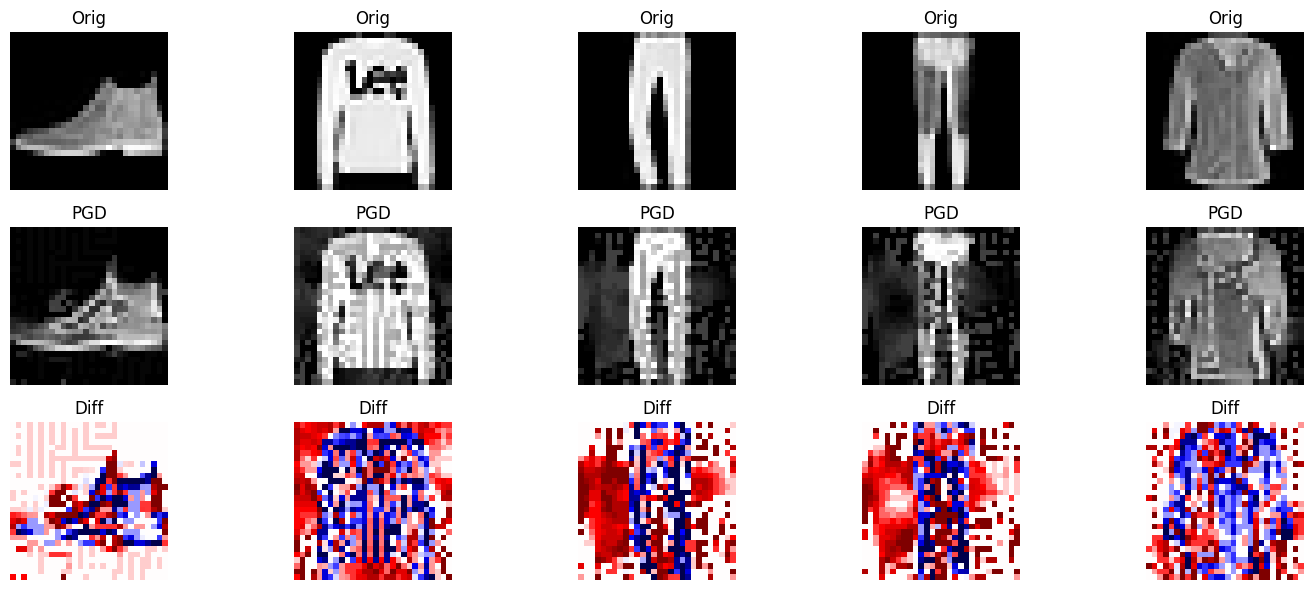


=== Dataset: CIFAR-10 ===

--- clean model ---


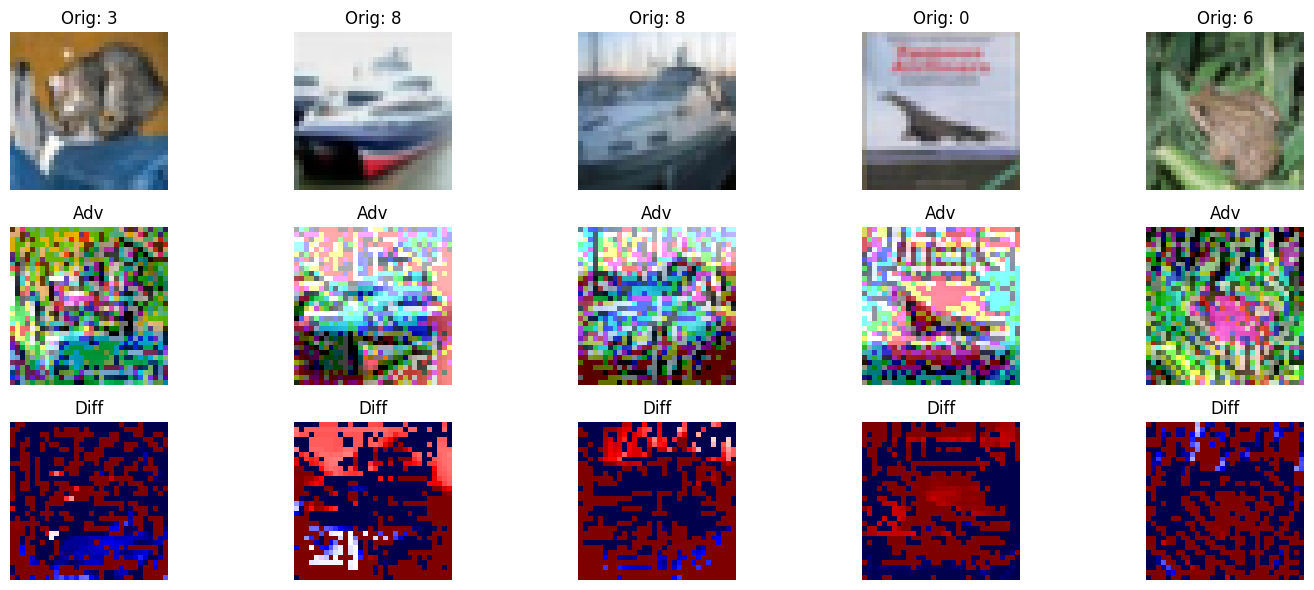

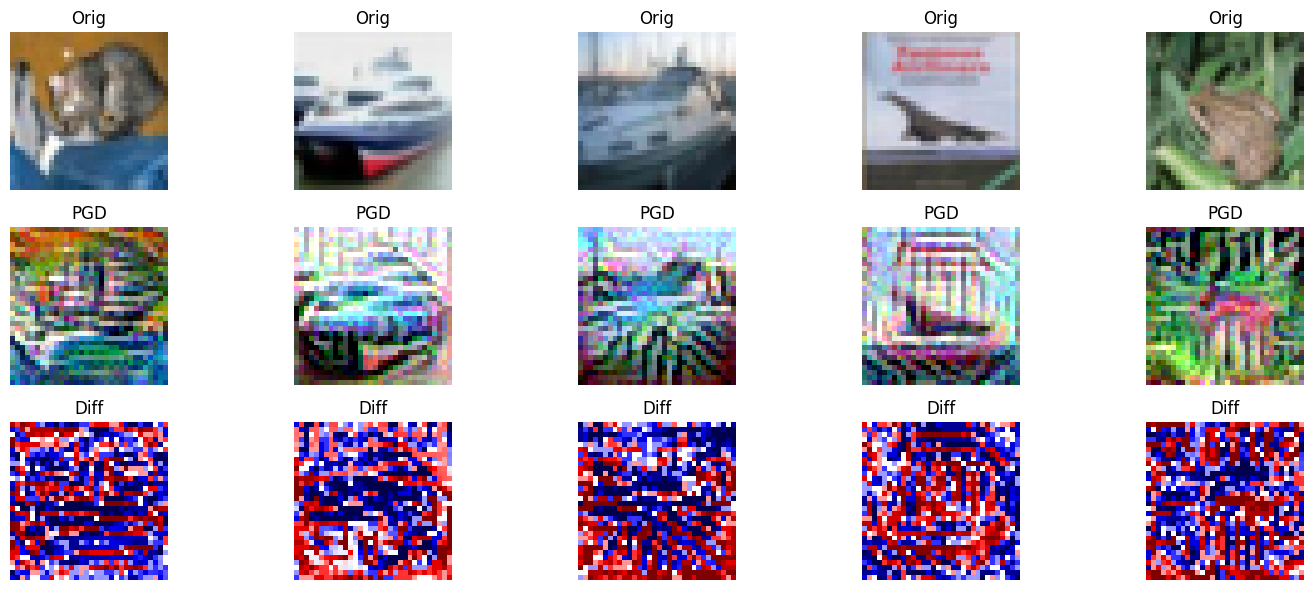


--- adv model ---


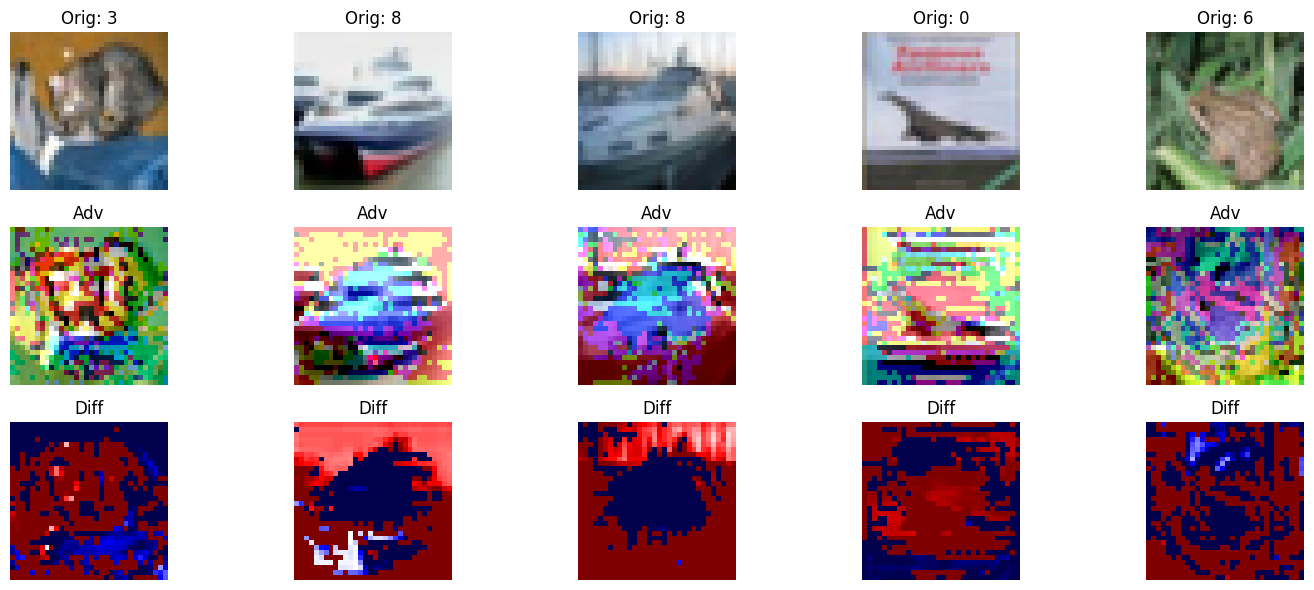

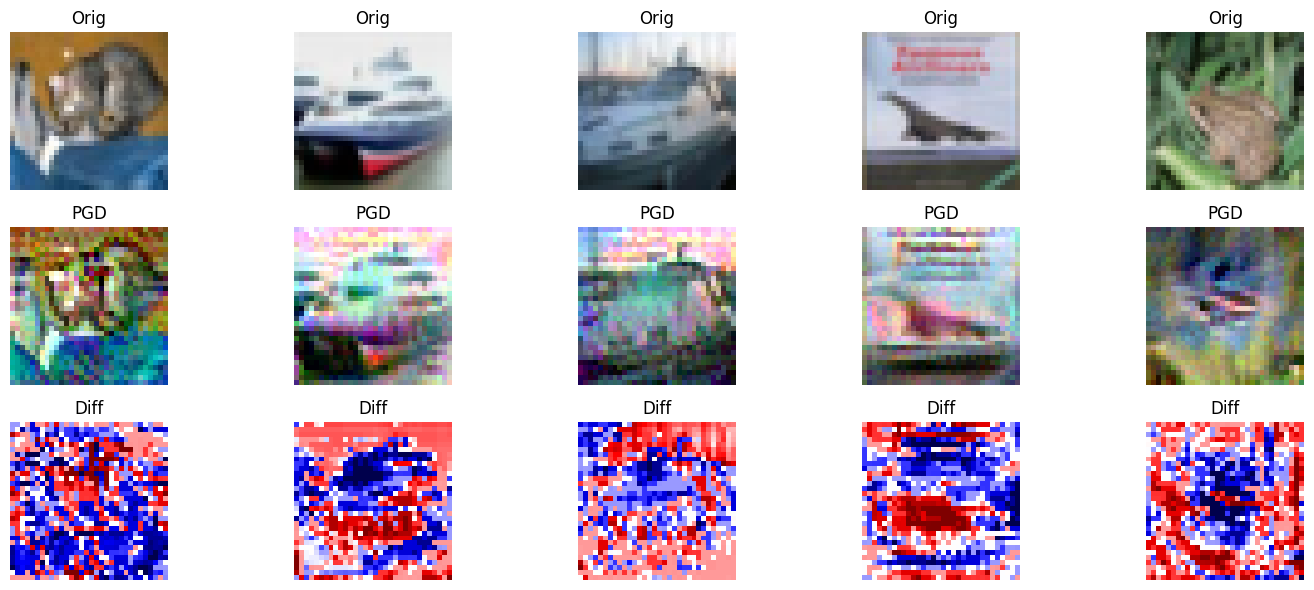

In [17]:
# boucle sur tous les datasets et modèles
for dataset_name, model_dict in models.items():
    print(f"\n=== Dataset: {dataset_name} ===")
    
    # récupère le loader correspondant
    test_loader = loaders[dataset_name]['test']
    
    for model_type, model in model_dict.items():
        print(f"\n--- {model_type} model ---")
        
        # FGSM adversarial examples
        show_adversarial_examples(model, test_loader, epsilon, device, n=min(n_visual, len(test_loader.dataset)))
        
        # PGD adversarial examples
        show_pgd_examples(model, test_loader, epsilon, alpha=epsilon / 10, num_iter=10, device=device, n=min(n_visual, len(test_loader.dataset)))
        

### Interprétation

- ADV = FGSM sign(gradient)
- pgd = descente de grad --> alpha descend pixel par pixel

Finalement epsilon agit comme un facteur d'échelle --> DEVELOPPER

En combinant l’évaluation sur plusieurs datasets avec des visualisations des exemples adversariaux et PGD, cette étude met en évidence :
- La robustesse est fortement dépendante de la linéarité locale et du type de réseau.
- Les méthodes classiques (regularisation, small FGSM) sont insuffisantes pour protéger complètement les modèles.
- Les attaques itératives comme PGD restent l’outil de référence pour tester la robustesse réelle des modèles.

#### Impact du choix des datasets sur la linéarité locale

En comparant MNIST, Fashion-MNIST et CIFAR-10, on observe que les modèles propres (non adversarially trained) présentent des niveaux de linéarité locale différents selon le dataset.

Malgré ces variations, la vulnérabilité aux attaques PGD est présente sur tous les datasets. Cela confirme que la linéarité locale est un problème intrinsèque aux architectures étudiées, et non spécifique à un dataset particulier.

Les datasets plus complexes (CIFAR-10) montrent souvent des valeurs de linéarité légèrement plus élevées et des perturbations PGD plus structurées, mais la tendance générale reste la même : plus la linéarité locale est élevée, plus le modèle est sensible aux adversaires.

Ainsi, même si le choix du dataset influence légèrement les valeurs numériques, le phénomène de vulnérabilité reste généralisable.

In [18]:
# ajouter figure comparaison linéarité et pgd pr chaq dataset

### Conclusion

Les expériences menées sur MNIST, Fashion-MNIST et CIFAR-10 confirment que la vulnérabilité des réseaux de neurones aux attaques adversariales est largement liée à leur linéarité locale, indépendamment de la profondeur ou de la taille des couches. Les modèles clean présentent des zones fortement linéaires dans l’espace des logits, qui sont exploitées par FGSM et encore plus par les attaques itératives PGD. Même après entraînement adversarial, la linéarité locale n’est pas complètement éliminée, mais sa structure est modifiée, ce qui améliore la robustesse tout en conservant une bonne performance sur les données propres.

BOFBOF à améliorer